In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D,BatchNormalization

In [2]:
data_dir = 'F:\datasets\Kaggle\SubsetVMMR'

In [3]:
data_dir

'F:\\datasets\\Kaggle\\SubsetVMMR'

In [4]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('F:/datasets/Kaggle/SubsetVMMR')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

1000

In [6]:
honda_civic = list(data_dir.glob('honda_civic/*'))
honda_civic[:5]

[WindowsPath('F:/datasets/Kaggle/SubsetVMMR/honda_civic/00C0C_jlHl4AvLK7I_600x450.jpg'),
 WindowsPath('F:/datasets/Kaggle/SubsetVMMR/honda_civic/00J0J_fvYqT8KEtmh_600x450.jpg'),
 WindowsPath('F:/datasets/Kaggle/SubsetVMMR/honda_civic/00P0P_b9EIKEIV6JC_600x450.jpg'),
 WindowsPath('F:/datasets/Kaggle/SubsetVMMR/honda_civic/00w0w_2a3iPidoCDQ_600x450.jpg'),
 WindowsPath('F:/datasets/Kaggle/SubsetVMMR/honda_civic/1997 honda civic lx_00b0b_gZ9nIca13C0_600x450.jpg')]

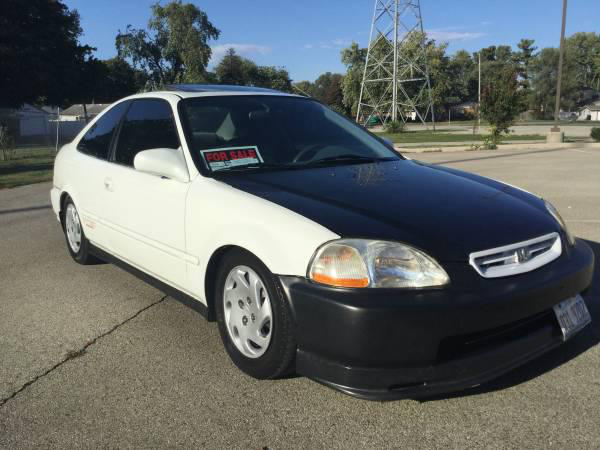

In [7]:
PIL.Image.open(str(honda_civic[29]))

In [8]:
cars_image_dic = {
    'chevrolet_impala': list(data_dir.glob('chevrolet_impala/*')),
    'chevrolet_silverado': list(data_dir.glob('chevrolet_silverado/*')),
    'dodge_ram_1500': list(data_dir.glob('dodge_ram_1500/*')),
    'ford_f150': list(data_dir.glob('ford_f150/*')),
    'gmc_sierra_1500': list(data_dir.glob('gmc_sierra_1500/*')),
    'honda_accord': list(data_dir.glob('honda_accord/*')),
    'honda_civic': list(data_dir.glob('honda_civic/*')),
    'nissan_altima': list(data_dir.glob('nissan_altima/*')),
    'toyota_camry': list(data_dir.glob('toyota_camry/*')),
    'toyota_corolla': list(data_dir.glob('toyota_corolla/*')),
}

In [9]:
cars_labels_dic = {
    'chevrolet_impala': 0,
    'chevrolet_silverado': 1,
    'dodge_ram_1500': 2,
    'ford_f150': 3,
    'gmc_sierra_1500': 4,
    'honda_accord': 5,
    'honda_civic': 6,
    'nissan_altima': 7,
    'toyota_camry': 8,
    'toyota_corolla': 9,
}

In [10]:
str(cars_image_dic['chevrolet_impala'][0])

'F:\\datasets\\Kaggle\\SubsetVMMR\\chevrolet_impala\\00101_7mjApj3wb7Y_600x450.jpg'

In [11]:
img = cv2.imread(str(cars_image_dic['chevrolet_impala'][0]))
img.shape

(450, 600, 3)

In [12]:
cv2.resize(img,(227,227)).shape

(227, 227, 3)

In [13]:
X, y = [], []

for cars_name, images in cars_image_dic.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(227,227))
        X.append(resized_img)
        y.append(cars_labels_dic[cars_name])

In [14]:
X = np.array(X)
y = np.array(y)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)

In [16]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

In [17]:
X_train_scaled.shape

(750, 227, 227, 3)

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(227, 
                                                              227,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [19]:
model = Sequential()

model.add(data_augmentation)
# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11),\
 strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Pooling 
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())

# Passing it to a dense layer
model.add(Flatten())
# 1st Dense Layer
model.add(Dense(4096, input_shape=(227*227*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# 3rd Dense Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

# Output Layer
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 227, 227, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 27, 27, 256)      

In [20]:
optimizer = keras.optimizers.Nadam(lr=0.001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train_scaled, y_train,batch_size=25, epochs=100)

Epoch 1/100
30/30 [==============================] - 103s 3s/step - loss: 3.2823 - accuracy: 0.1301
Epoch 2/100
30/30 [==============================] - 89s 3s/step - loss: 3.0598 - accuracy: 0.1196
Epoch 3/100
30/30 [==============================] - 93s 3s/step - loss: 2.8803 - accuracy: 0.1334
Epoch 4/100
30/30 [==============================] - 88s 3s/step - loss: 2.5410 - accuracy: 0.1904
Epoch 5/100
30/30 [==============================] - 88s 3s/step - loss: 2.3824 - accuracy: 0.2174
Epoch 6/100
30/30 [==============================] - 88s 3s/step - loss: 2.3418 - accuracy: 0.2446
Epoch 7/100
30/30 [==============================] - 99s 3s/step - loss: 2.2773 - accuracy: 0.2491
Epoch 8/100
30/30 [==============================] - 109s 4s/step - loss: 2.1090 - accuracy: 0.3064
Epoch 9/100
30/30 [==============================] - 107s 4s/step - loss: 2.0771 - accuracy: 0.3095
Epoch 10/100
30/30 [==============================] - 100s 3s/step - loss: 2.0278 - accuracy: 0.3099
Epoch

In [21]:
model.evaluate(X_test_scaled, y_test)

8/8 [==============================] - 11s 1s/step - loss: 3.5610 - accuracy: 0.4400


[3.5610101222991943, 0.4399999976158142]